# Introduction
This code replicates the Google Colab topic modeling notebook for use on Jupyter Notebook or another local Python environment.

Below, Gensim is used to create LDA topic models of a pre-loaded dataframe of texts. Methods for evaluating topic coherence and analyzing topic output are also demonstrated. 

This code is adapted from [Intro to Topic Modeling with Gensim and pyLDAvis](https://github.com/hawc2/text-analysis-with-python/blob/master/Topic_Modeling.ipynb) and works well with input from from the Text Sectioning and Disaggregation code from [this repository](https://github.com/SF-Nexus/Extracted-Features).



# Install Packages
This code requires three main packages:
- **NLTK:** Cleaning disaggregated data
- **Gensim:** Preprocessing data and creating word embeddings, coherence models and topic models
- **LDAvis:** Visualizing topic models

Several other packages for wrangling and processing the data, such as io and pandas, will also be installed. 

In [1]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/megankane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [4]:
import numpy as np
import pandas as pd
import io
import re
from pprint import pprint

# Retrieve and Convert Corpus to Data Frame

This code requires the upload of a previously created dataframe which contains a corpus of disaggregated texts. For optimal use, this dataframe should also contain labels associated with each text (e.g. book or chapter numbers). 

In [6]:
##Define working directory 

#Upload dataframe
import pandas as pd
df = pd.read_csv('chapters_sample.csv')
df

Unnamed: 0                                Book + Chapter  \
0            0               1958_ALDISS_STARSHIP _Chapter_0   
1            1               1958_ALDISS_STARSHIP _Chapter_1   
2            2               1958_ALDISS_STARSHIP _Chapter_2   
3            3               1958_ALDISS_STARSHIP _Chapter_3   
4            4               1958_ALDISS_STARSHIP _Chapter_4   
..         ...                                           ...   
77          77   1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_7   
78          78   1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_8   
79          79   1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_9   
80          80  1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_10   
81          81  1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_11   

                                                 Text  
0                                     1 PART Quarters  
1   1 A A A A A Again All Almost Although An And A...  
2   1 2 A A A A A A A A A A Added All An An And An...  
3   3 A A A A A A Ah All Almost Although And And A...  
4   2 4 A A A A After All Always An And And And An...  
..                                                ...  
77  1 1 1 4 5 7 A A A A A After After After Ah All...  
78  1 1mperator 8 A A A A A A A A According Accord...  
79  0 1 5 5 5 6 6 6 6 9 A A A A A A A A A A A A A ...  
80  1 10 161 A A A Absol Absol Achronal Achronal A...  
81  11 Absol Dwight He His Humbart Humbart Imperat...  

[82 rows x 3 columns]

In [7]:
#Drop any empty cells
df = df.dropna()
df

Unnamed: 0                                Book + Chapter  \
0            0               1958_ALDISS_STARSHIP _Chapter_0   
1            1               1958_ALDISS_STARSHIP _Chapter_1   
2            2               1958_ALDISS_STARSHIP _Chapter_2   
3            3               1958_ALDISS_STARSHIP _Chapter_3   
4            4               1958_ALDISS_STARSHIP _Chapter_4   
..         ...                                           ...   
77          77   1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_7   
78          78   1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_8   
79          79   1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_9   
80          80  1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_10   
81          81  1974_BAYLEY_THEFALLOFCHRONOPOLIS _Chapter_11   

                                                 Text  
0                                     1 PART Quarters  
1   1 A A A A A Again All Almost Although An And A...  
2   1 2 A A A A A A A A A A Added All An An And An...  
3   3 A A A A A A Ah All Almost Although And And A...  
4   2 4 A A A A After All Always An And And And An...  
..                                                ...  
77  1 1 1 4 5 7 A A A A A After After After Ah All...  
78  1 1mperator 8 A A A A A A A A According Accord...  
79  0 1 5 5 5 6 6 6 6 9 A A A A A A A A A A A A A ...  
80  1 10 161 A A A Absol Absol Achronal Achronal A...  
81  11 Absol Dwight He His Humbart Humbart Imperat...  

[80 rows x 3 columns]

In [8]:
#Add values in Text column to new list (for further cleaning)
data = df.Text.values.tolist()

# Clean Texts
Below are several preprocessing measures to help improve quality of text used for the topic model. Some may or may not be useful depending on specifications of corpus or goals of topic modeling:
- **Stopword Removal:** Removes globally common words from corpus which may skew topics; some stopwords may be useful for analysis and some studies show that removing more than the top 10 most common words does not significantly impact topic model results 
- **Bigrams/Trigram Modeling:** Recognizes common 2- and 3-word phrases to prevent disambiguation (e.g. spaceship vs. space, ship); may misidentify phrases especially in corpora with large/uncommon vocabularies like sci-fi
- **Lemmatization:** Transforms words to root form to aid recognition; some studies show may be redundant, unnecessary or even inaccurate in conflating differing words with same root meanings 

*Read More:*

https://maria-antoniak.github.io/2022/07/27/topic-modeling-for-the-people.html

https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2


In [9]:
#Define list of stopwords
stop_words = stopwords.words('english')

# Add further stopwords by simply "appending" desired words to dictionary
stop_words.append('CHAPTER')

In [10]:
#Remove punctuation
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
data = [re.sub('\s+', ' ', sent) for sent in data]
data = [re.sub("\'", "", sent) for sent in data]

<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \S
<>:3: DeprecationWarning: invalid escape sequence \s
/var/folders/8k/6tq9yjnx511d5q4fkv00y_600000gn/T/ipykernel_15407/3478888187.py:2: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
/var/folders/8k/6tq9yjnx511d5q4fkv00y_600000gn/T/ipykernel_15407/3478888187.py:3: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


In [11]:
#Define function to perform simple preprocessing on text
def sent_to_words(sentences):
    for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [12]:
#Run processing function on texts
data_words = list(sent_to_words(data))
#print(data_words[:1])

In [13]:
#Define stopword removal
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc))
if word not in stop_words] for doc in texts]

#Define function to make bigrams
def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
#   return [trigram_mod[bigram_mod[doc]] for doc in texts]

#Define function to lemmatize texts
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
     doc = nlp(" ".join(sent))
     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

In [14]:
#Define bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=1, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [15]:
#Run functions to remove stopwords, make bigrams, and lemmatize text
data_words = remove_stopwords(data_words)
#data_words_bigrams = make_bigrams(data_nostops)
#data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
#print(data_lemmatized[:4])

In [16]:
data_words

[['part', 'quarters'],
 ['almost',
  'although',
  'another',
  'ansa',
  'anything',
  'aware',
  'bergass',
  'bergass',
  'bergass',
  'besides',
  'better',
  'beyond',
  'bob',
  'bob',
  'bob',
  'cheap',
  'cheap',
  'cheap',
  'cheap',
  'cheer',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complain',
  'complains',
  'complains',
  'complains',
  'complains',
  'complains',
  'complains',
  'complains',
  'complains',
  'consequently',
  'create',
  'daise',
  'dimly',
  'disease',
  'dont',
  'dont',
  'dont',
  'dont',
  'easy',
  'eff',
  'eff',
  'eff',
  'eff'

# Building Dictionary and Corpus
Once the dataset is cleaned, two inputs must be created to run the topic model. Creating the dictionary maps every word in the corpus with a unique id number. The variable corpus is calculated by determining the frequency of each word in the document. Another optional cleaning measure can be used here--removing words that are extremely rare (existing in < n number of texts) or common (existing in > n number of texts).  

In [17]:
# Import dictionary
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(data_words)

#Calculate term document frequency for each word in dataset
corpus = [dictionary.doc2bow(doc) for doc in data_words]
corpus

[[(0, 1), (1, 1)],
 [(0, 1),
  (1, 12),
  (2, 1),
  (3, 1),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 2),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 1),
  (17, 1),
  (18, 1),
  (19, 1),
  (20, 1),
  (21, 1),
  (22, 1),
  (23, 1),
  (24, 1),
  (25, 2),
  (26, 2),
  (27, 1),
  (28, 8),
  (29, 2),
  (30, 3),
  (31, 4),
  (32, 2),
  (33, 4),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 4),
  (39, 1),
  (40, 2),
  (41, 4),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 1),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 2),
  (58, 1),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 6),
  (66, 1),
  (67, 1),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 1),
  (72, 2),
  (73, 1),
  (74, 2),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 15),
  (79, 1),
  (80, 1),
  (81, 11),
  (82, 1),
  (83, 2),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 8),
  (89, 4)

In [18]:
# OPTIONAL cleaning: filter out words that occur less than 20 documents, or more than 50% of the documents.
#dictionary.filter_extremes(no_below=2, no_above=0.8)

In [18]:
#Get number of unique tokens and documents
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 21109
Number of documents: 80


# Find Optimal Number of Topics

Calculating topic model coherence (i.e. similarity between the highest-scoring words in each topic) is one way to assess the optimal number of topics to use when creating and visualizing topic models. Below are two methods of calculating coherence: **C_V coherence**, which is calculated based on word co-occurences, and **U_Mass coherence**, which is calculated based on how frequently documents containing high-scoring words co-occur in the corpus. Both have been used in prior research and either may yield better results, depending on corpus specifications.

Additional readings: 

https://aclanthology.org/D12-1087.pdf 

https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

## C_V Coherence Calculations

The function below calculates C_V coherence scores for n topic models run based on set parameters. Coherence is calculated on a range of 0 < x < 1 where higher-scoring models are assumed more coherent. For example, a model with a score of .50 is more coherent than a model with a .25 score.  

In [20]:
#Define list for model and coherence values
coherence = []

#Find coherence for set range of models and append to list
for k in range(2,200):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k, \
               id2word = dictionary, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=data_words,\
         dictionary=dictionary, coherence='c_v')   
                                                
    coherence.append((k,cm.get_coherence()))

Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Round: 30
Round: 31
Round: 32
Round: 33
Round: 34
Round: 35
Round: 36
Round: 37
Round: 38
Round: 39
Round: 40
Round: 41
Round: 42
Round: 43
Round: 44
Round: 45
Round: 46
Round: 47
Round: 48
Round: 49
Round: 50
Round: 51
Round: 52
Round: 53
Round: 54
Round: 55
Round: 56
Round: 57
Round: 58
Round: 59
Round: 60
Round: 61
Round: 62
Round: 63
Round: 64
Round: 65
Round: 66
Round: 67
Round: 68
Round: 69
Round: 70
Round: 71
Round: 72
Round: 73
Round: 74
Round: 75
Round: 76
Round: 77
Round: 78
Round: 79
Round: 80
Round: 81
Round: 82
Round: 83
Round: 84
Round: 85
Round: 86
Round: 87
Round: 88
Round: 89
Round: 90
Round: 91
Round: 92
Round: 93
Round: 94
Round: 95
Round: 96
Round: 97
Round: 98
Round: 99
Round: 100
Round: 101
Round:

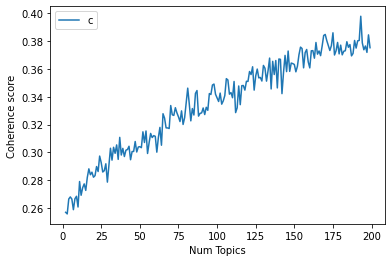

In [21]:
# Transpose coherence data
x, y = np.array(coherence).T
  
      
# plot our list in X,Y coordinates
optimal, = plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [22]:
#Get coherence score for each num topics sorted from highest to lowest
#Highest value will be optimal number of topics
Data = {'Num Topics': optimal.get_xdata(), 'Coherence': optimal.get_ydata()}
type(Data)
df_optimal = pd.DataFrame.from_dict(Data)
df_optimal.sort_values(by='Coherence',ascending=False).head()

Num Topics  Coherence
191       193.0   0.397845
173       175.0   0.385948
168       170.0   0.384763
196       198.0   0.384452
167       169.0   0.384025

## U_Mass Coherence Calculation
The function below calculates U_Mass coherence scores of n topic models run based on set parameters. Coherence is calculated on a range of -14 < x < 14 where lower-scoring models are more coherent. For example, a model with a score of -.4 is less coherent than a model with a -.9 score. 


In [23]:
#Define list for model and coherence values
coherence2 = []

#Find coherence for set range of models and append to list
for k in range(2,200):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(corpus, num_topics=k, \
               id2word = dictionary, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=data_words,\
         dictionary=dictionary, coherence='u_mass')   
                                                
    coherence2.append((k,cm.get_coherence()))

Round: 2
Round: 3
Round: 4
Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25
Round: 26
Round: 27
Round: 28
Round: 29
Round: 30
Round: 31
Round: 32
Round: 33
Round: 34
Round: 35
Round: 36
Round: 37
Round: 38
Round: 39
Round: 40
Round: 41
Round: 42
Round: 43
Round: 44
Round: 45
Round: 46
Round: 47
Round: 48
Round: 49
Round: 50
Round: 51
Round: 52
Round: 53
Round: 54
Round: 55
Round: 56
Round: 57
Round: 58
Round: 59
Round: 60
Round: 61
Round: 62
Round: 63
Round: 64
Round: 65
Round: 66
Round: 67
Round: 68
Round: 69
Round: 70
Round: 71
Round: 72
Round: 73
Round: 74
Round: 75
Round: 76
Round: 77
Round: 78
Round: 79
Round: 80
Round: 81
Round: 82
Round: 83
Round: 84
Round: 85
Round: 86
Round: 87
Round: 88
Round: 89
Round: 90
Round: 91
Round: 92
Round: 93
Round: 94
Round: 95
Round: 96
Round: 97
Round: 98
Round: 99
Round: 100
Round: 101
Round:

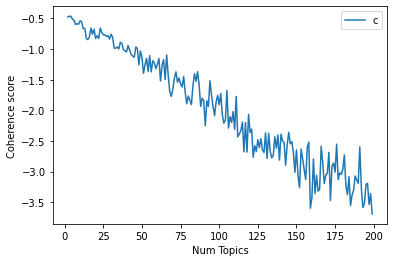

In [24]:
# Transpose coherence data
x, y = np.array(coherence2).T
        
# plot our list in X,Y coordinates
optimal2, = plt.plot(x, y)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [25]:
#Get coherence score for each num topics sorted from highest to lowest
#Lowest value will be optimal number of topics
Data = {'Num Topics': optimal2.get_xdata(), 'Coherence': optimal2.get_ydata()}
type(Data)
df_optimal2 = pd.DataFrame.from_dict(Data)
df_optimal2.sort_values(by='Coherence',ascending=True).head()

Num Topics  Coherence
197       199.0  -3.691400
157       159.0  -3.598054
191       193.0  -3.585079
183       185.0  -3.553698
195       197.0  -3.537517

# Create Topic Models with Optimal Parameters
Input the parameters of the topic model and run. The model has multiple parameters, including: 
- num_topics: Number of topics the model will generate (default = 100)
- chunksize: Number of documents processed at a time (default = 2000)
- passes: Number of times model is trained on corpus (default = 1)
- iterations: Number of times model "loops" over each document (default = 50)

Calculating coherence (above) helps determine topic number, and other methods can be used to determine appropriate values for the other parameters. 

**Chunk size:** Setting chunk size to a larger number than that of documents in the model ensures that all documents are processed at once (though this requires enough memory space). 

**Passes and Iterations:** A common way to determine the best number of passes and iterations is by training a topic model and checking the "log" to see the document convergence rate (what percentage of topic/word assignments attain stability). If convergence is low, increase number of passes and interations. 

In general, as chunksize increases, passes and iterations should increase as well. Also keep in mind that corpus size may effect number of topics--in the cases of smaller corpora, using too many topics will likely make them too general OR too limited to the context of only one text. Consider running multiple models and comparing coherence, perplexity, and top words per topic. 

Additional reading: 

https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#12buildingthetopicmodel

In [19]:
#Import logging to gauge passes and iterations; will output file to working directory
import logging
logging.basicConfig(filename='gensim.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.INFO)

In [21]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 99
chunksize = 100
passes = 20
iterations = 40
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=1
)

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute C_V Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.970852630716603

Coherence Score:  0.4867747585086752


# Examine Topic Model Output
Once the model has been run, it is possible to retrieve the top words in each topic and visualing the model. These are methods can help further assess model coherence and point to future directions for analysis:
- **Top Words Per Topic:** Evaluate to what extent each topic contains semantically similar words, how/why these words might be meaningful in context of corpus
- **Visualizations:** Determine topic relatedness (how far apart topic circles are on plane) and topic prevalence (how large circles are corresponds to topic prevaence in corpus)

Additional reading: 

https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#15visualizethetopicskeywords

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/


In [23]:
#Print n number of words in each topic
for idx, topic in lda_model.print_topics(num_words=8):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 61 
Words: 0.000*"one" + 0.000*"back" + 0.000*"time" + 0.000*"could" + 0.000*"said" + 0.000*"larry" + 0.000*"left" + 0.000*"would"
Topic: 20 
Words: 0.000*"one" + 0.000*"back" + 0.000*"said" + 0.000*"two" + 0.000*"door" + 0.000*"larry" + 0.000*"window" + 0.000*"would"
Topic: 11 
Words: 0.000*"said" + 0.000*"would" + 0.000*"time" + 0.000*"larry" + 0.000*"one" + 0.000*"back" + 0.000*"ship" + 0.000*"could"
Topic: 40 
Words: 0.000*"said" + 0.000*"one" + 0.000*"back" + 0.000*"could" + 0.000*"like" + 0.000*"would" + 0.000*"two" + 0.000*"dont"
Topic: 81 
Words: 0.000*"said" + 0.000*"time" + 0.000*"one" + 0.000*"could" + 0.000*"would" + 0.000*"back" + 0.000*"ship" + 0.000*"complain"
Topic: 75 
Words: 0.000*"could" + 0.000*"window" + 0.000*"one" + 0.000*"said" + 0.000*"back" + 0.000*"would" + 0.000*"time" + 0.000*"larry"
Topic: 18 
Words: 0.000*"said" + 0.000*"time" + 0.000*"one" + 0.000*"back" + 0.000*"could" + 0.000*"like" + 0.000*"left" + 0.000*"eyes"
Topic: 42 
Words: 0.000*"said" + 

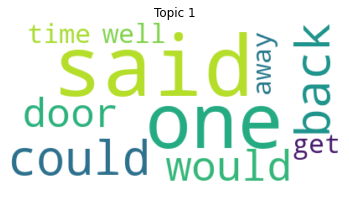

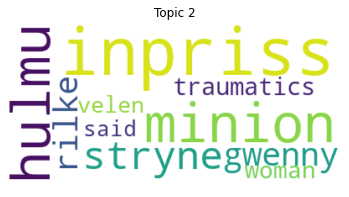

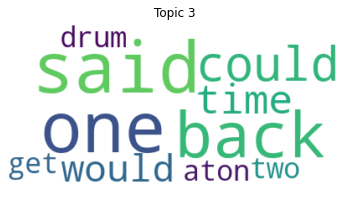

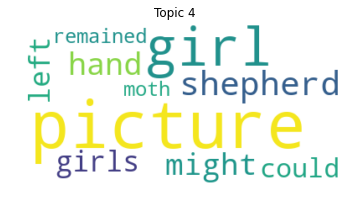

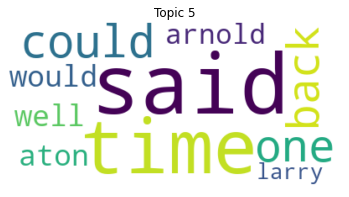

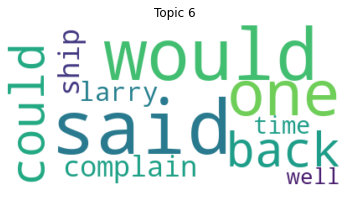

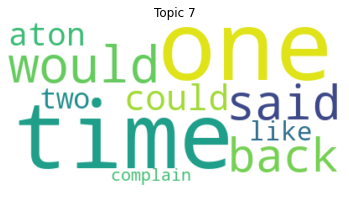

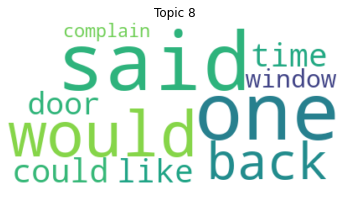

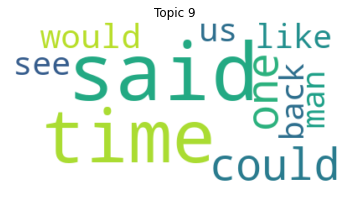

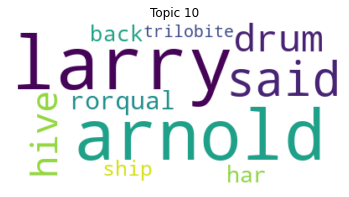

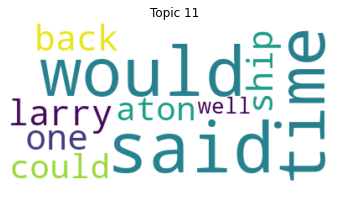

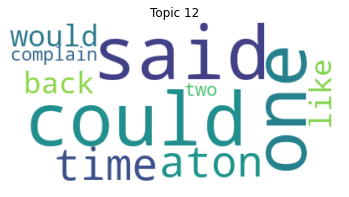

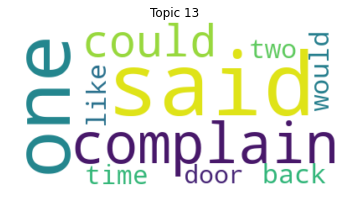

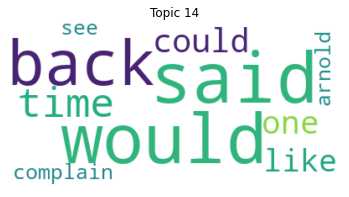

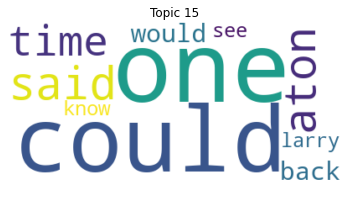

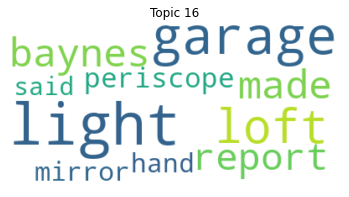

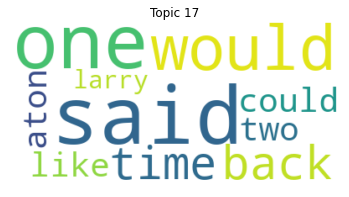

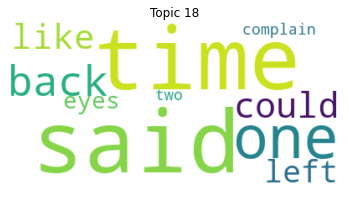

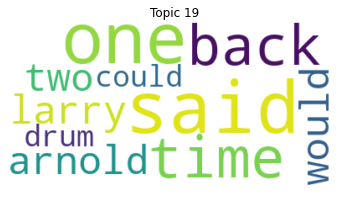

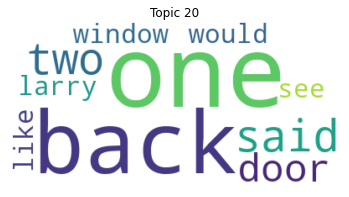

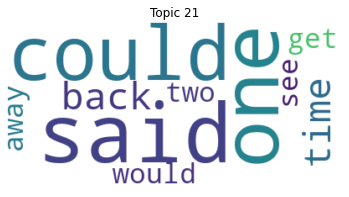

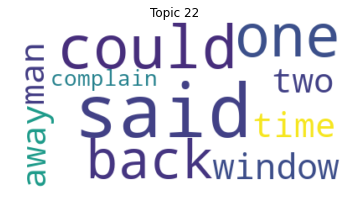

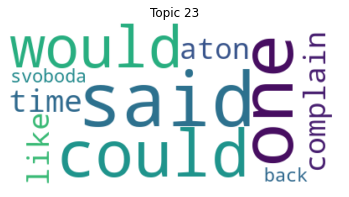

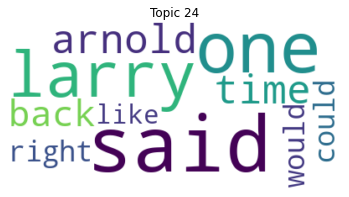

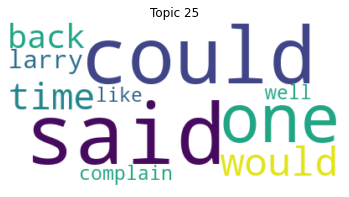

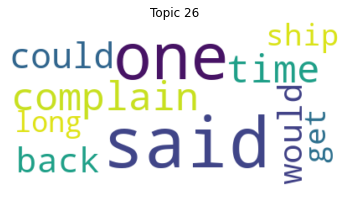

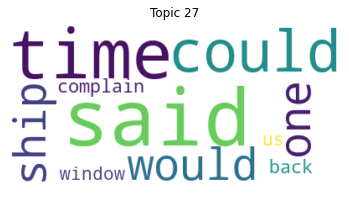

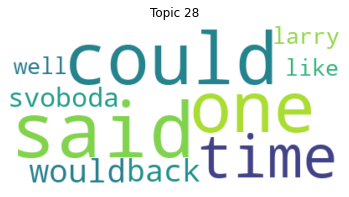

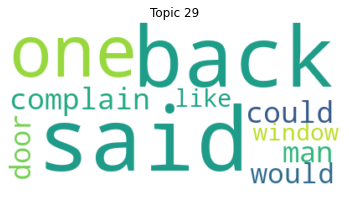

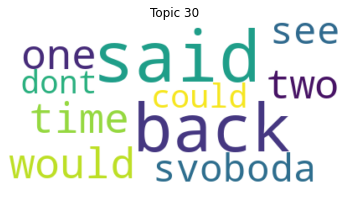

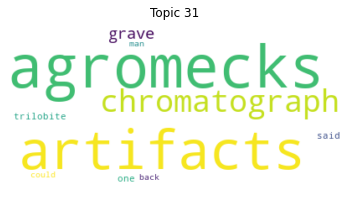

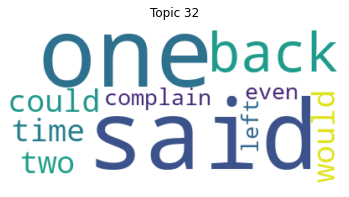

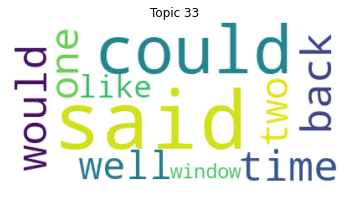

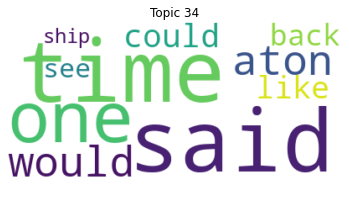

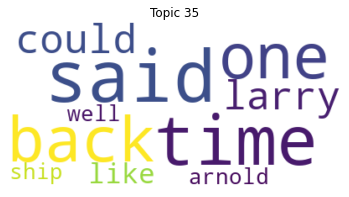

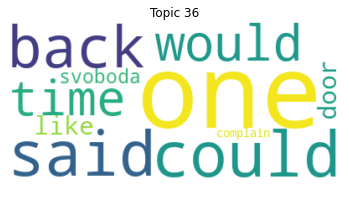

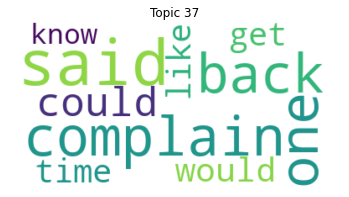

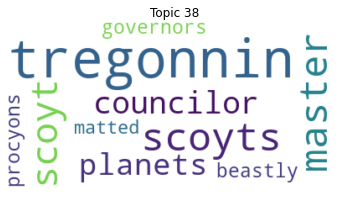

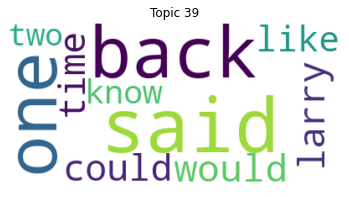

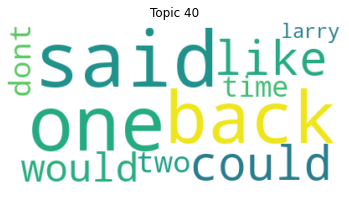

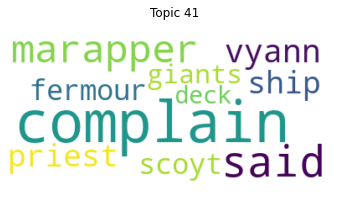

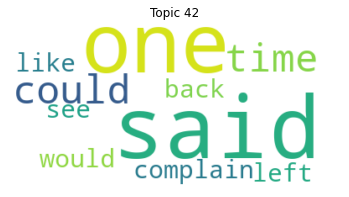

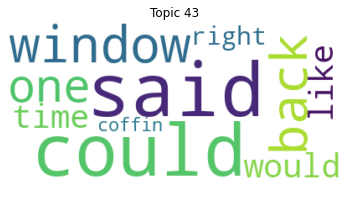

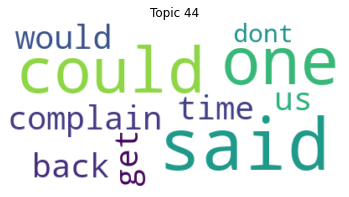

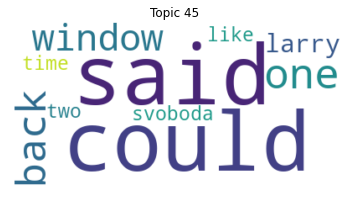

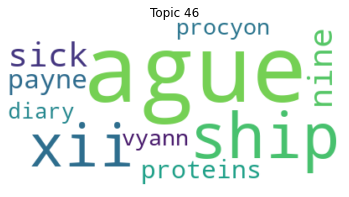

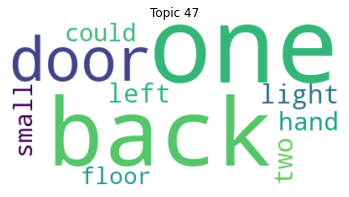

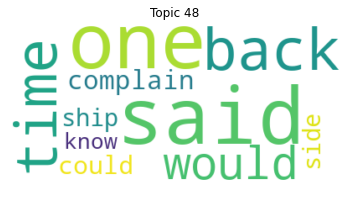

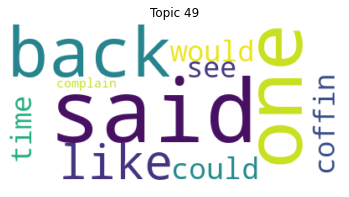

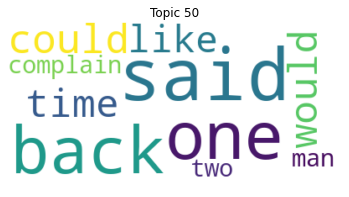

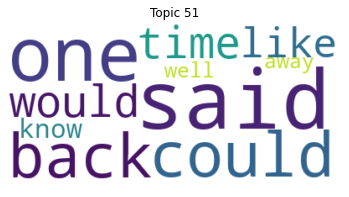

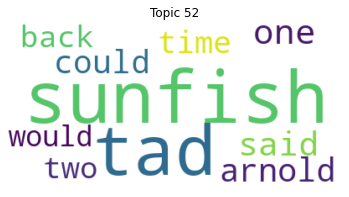

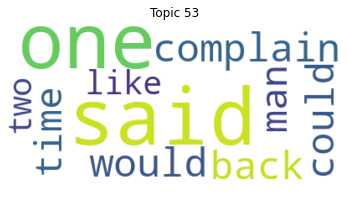

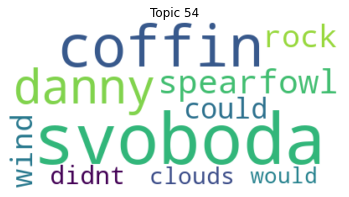

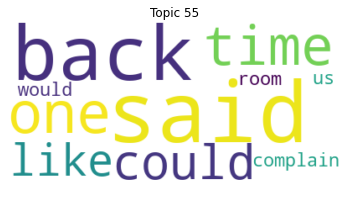

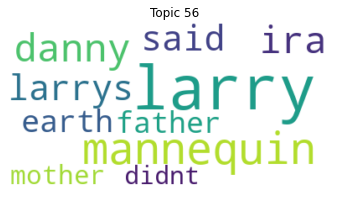

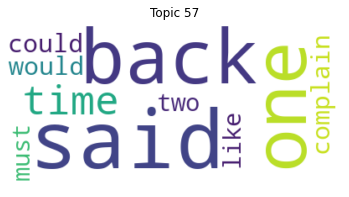

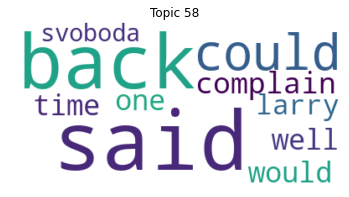

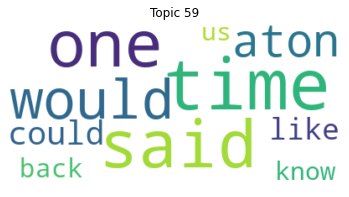

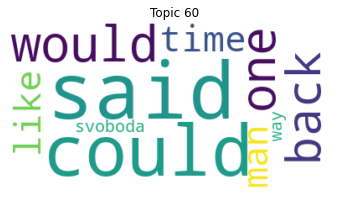

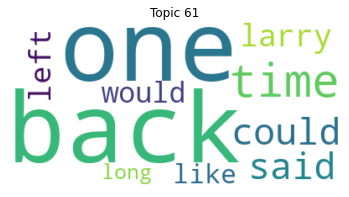

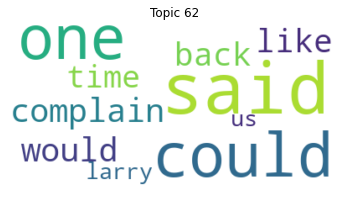

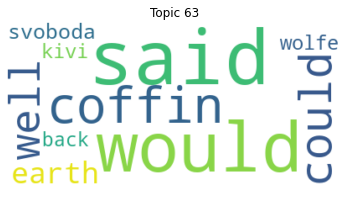

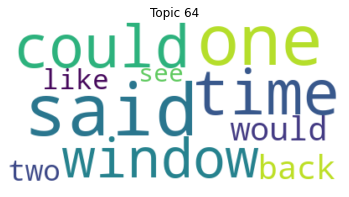

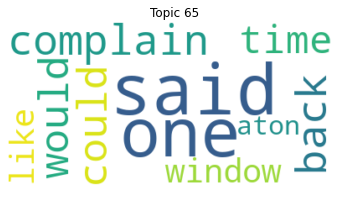

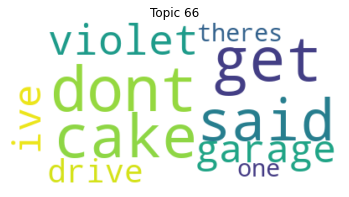

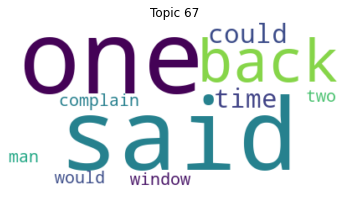

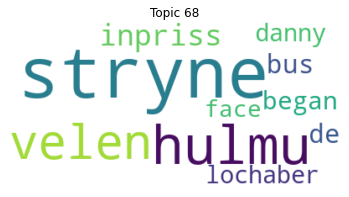

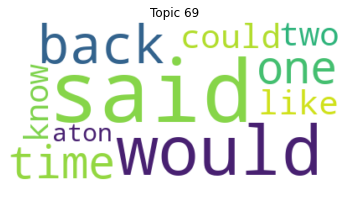

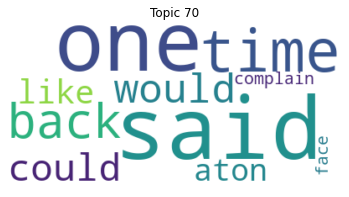

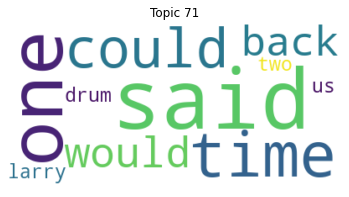

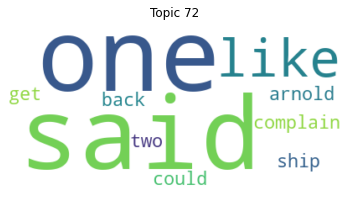

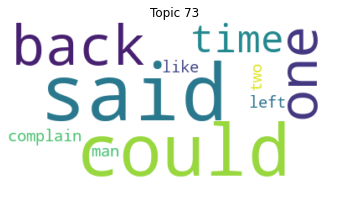

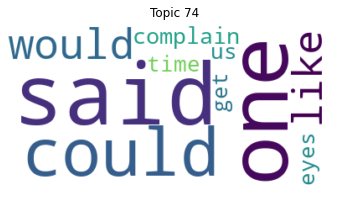

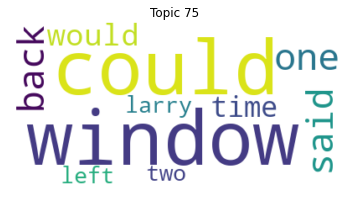

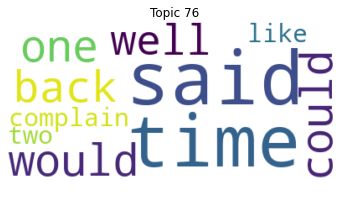

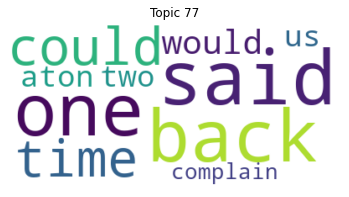

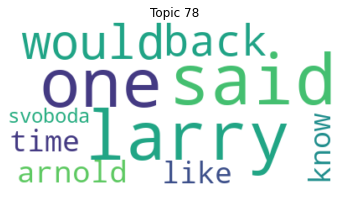

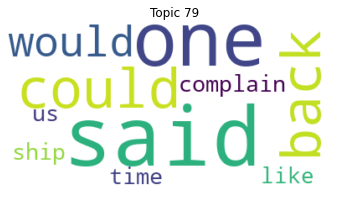

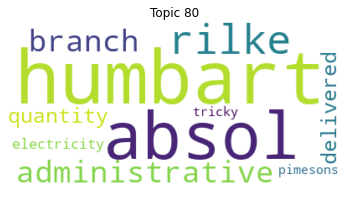

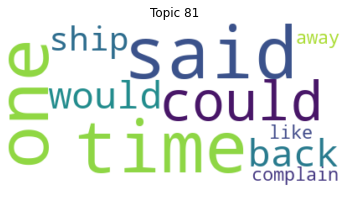

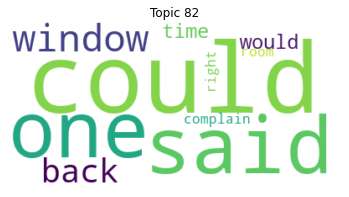

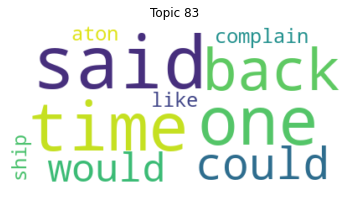

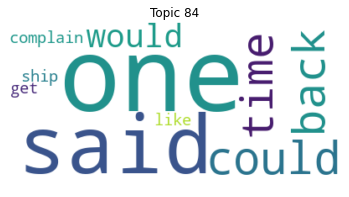

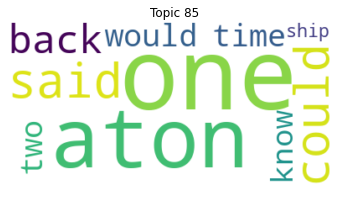

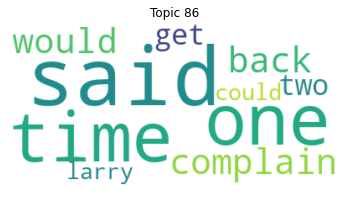

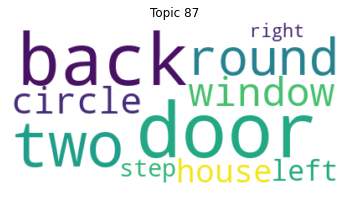

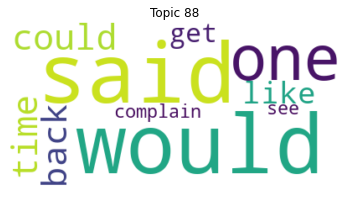

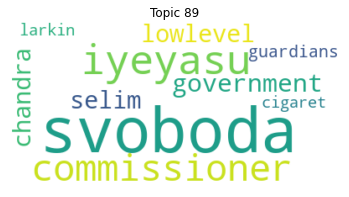

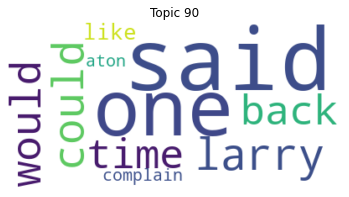

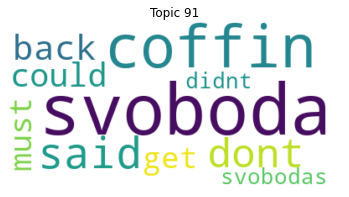

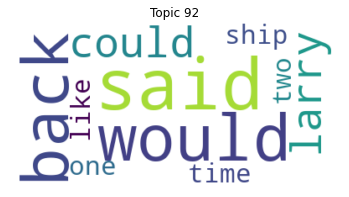

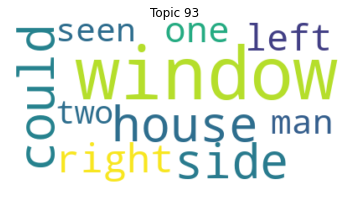

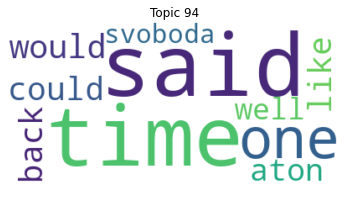

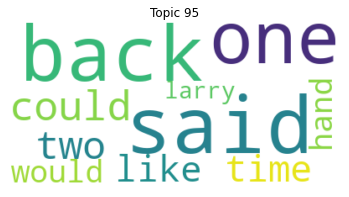

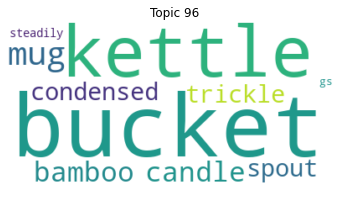

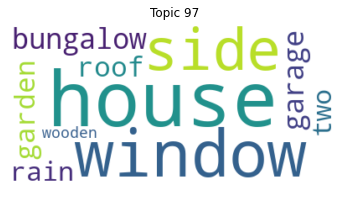

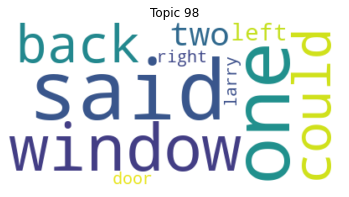

In [25]:
#Define word cloud function
from wordcloud import WordCloud 
def create_wordcloud(model, topic):
    text = {word: value for word, value in model.show_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic" + " "+ str(topic))
    plt.show()
    
#Ignore depreciation warnings
import warnings
warnings.filterwarnings("ignore")

#Create word clouds
for i in range(1,num_topics):
    create_wordcloud(lda_model, topic=i)

In [26]:
#Create visualization of topic model above 
%matplotlib inline
import pyLDAvis.gensim_models
vis = pyLDAvis.gensim_models.prepare(topic_model=lda_model, corpus=corpus, dictionary=dictionary)
pyLDAvis.enable_notebook()
pyLDAvis.display(vis)

In [27]:
#Create and view visualization CHECK IF THIS WORKS IN COLAB
vis = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis)

/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing t

/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing t

/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:34: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/megankane/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_least_angle.py:164: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing t

# Find Top Topics Per Document

Find the topic with highest percentage in each document in corpus. 

Additional reading: 
https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [ ]:
#Define function that retrieves dominant topic for each document and puts in dataframe
def format_topics_texts(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    text_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                text_topics_df = text_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    text_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    text_topics_df = pd.concat([text_topics_df, contents], axis=1)
    return(text_topics_df)

In [ ]:
#Run dominant topic function on corpus
df_topic_texts_keywords = format_topics_texts(ldamodel=lda_model, corpus=corpus, texts=data_words)

# Format
df_dominant_topic = df_topic_texts_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

# Find Top Documents Per Topic
Calculate the top documents attributed to each topic in the model. 

Additional reading:

https://stackoverflow.com/questions/63777101/topic-wise-document-distribution-in-gensim-lda

https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb 

https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#7.-The-most-representative-sentence-for-each-topic 

In [ ]:
#Add Book + Chapter labels to dataframe for easier ID
doc_names = df['Book + Chapter']
df_topic_texts_keywords = df_topic_texts_keywords.join(doc_names)

In [ ]:
# Get most representative text for each topic 
#Display setting to show more characters in column
pd.options.display.max_colwidth = 100

#Create new dataframe and group topic keywords by dominant topic column
topics_sorted_df = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_texts_keywords.groupby('Dominant_Topic')

#Sort data by percent contribution and select highest n values for each topic
for i, grp in sent_topics_outdf_grpd:
    topics_sorted_df = pd.concat([topics_sorted_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

In [ ]:
# Reset Index of new df
topics_sorted_df.reset_index(drop=True, inplace=True)

# Format
topics_sorted_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text", "Text Name"]
topics_sorted_df = topics_sorted_df.reindex(columns=['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text Name", "Representative Text"])
# Show
topics_sorted_df.head()

# Future step: Gensim word embeddings!

https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92 

https://www.shanelynn.ie/word-embeddings-in-python-with-spacy-and-gensim/

# Sources

**More Examples of Topic Modeling Research:**

*   http://www.digitalhumanities.org/dhq/vol/11/2/000291/000291.html
*   http://www.cs.columbia.edu/~blei/papers/Blei2011.pdf
*   https://maria-antoniak.github.io/resources/2019_cscw_birth_stories.pdf 

**More Topic Modeling Tools:**

*   https://github.com/polsci/colab-gensim-mallet/blob/master/topic-modeling-with-colab-gensim-mallet.ipynb
*   https://github.com/laurejt/authorless-tms 
*   https://colab.research.google.com/github/kldarek/skok/blob/master/_notebooks/2021-05-27-Topic-Models-Introduction.ipynb
